In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, recall_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

In [2]:
df = pd.read_csv("D:\Python project\Machine_learning_projects\DigitalJail_Users_1M.csv", low_memory=False)
print("Dataset loaded →", df.shape)
df.head()


Dataset loaded → (1000000, 5)


,user_id,username,account_status,join_date,notes
0,U000001,user891144,Active,2025-06-29,Verified user
1,U000002,user359980,Suspended,2023-12-11,Verified user
2,U000003,user801593,Restricted,2025-06-28,No issues found
3,U000004,user659050,Suspended,2023-05-30,Deleted due to inactivity
4,U000005,user341550,Restricted,2025-03-01,Verified user


In [3]:
target_col = "account_status" 
print("Selected target column:", target_col)


Selected target column: account_status


In [4]:
drop_like = [c for c in df.columns if c.lower() in ["id", "user_id", "uid", "index"]]
df = df.drop(columns=drop_like, errors="ignore")

In [5]:
X = df.drop(columns=[target_col])
y = df[target_col]


In [6]:
X = X.dropna(axis=1, thresh=int(0.1 * len(X)))  # keep cols with ≥10 % non-null
X = X.loc[:, X.nunique() > 1]


In [7]:
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()


In [8]:
num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="constant", fill_value="MISSING")
if num_cols:
    X[num_cols] = num_imputer.fit_transform(X[num_cols])
if cat_cols:
    X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])


In [9]:
for c in cat_cols:
    top = X[c].value_counts().nlargest(100).index
    X[c] = X[c].where(X[c].isin(top), "__OTHER__")

In [10]:
ohe_cols = [c for c in cat_cols if X[c].nunique() <= 20]
le_cols = [c for c in cat_cols if c not in ohe_cols]

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_ohe = pd.DataFrame()
if ohe_cols:
    X_ohe = pd.DataFrame(
        ohe.fit_transform(X[ohe_cols]),
        index=X.index,
        columns=ohe.get_feature_names_out(ohe_cols)
    )

In [11]:
for c in le_cols:
    le = LabelEncoder()
    X[c] = le.fit_transform(X[c].astype(str))
    

In [12]:
X_final = pd.concat(
    [X[num_cols].reset_index(drop=True),
     X[le_cols].reset_index(drop=True),
     X_ohe.reset_index(drop=True)], axis=1
)
print("Final feature matrix:", X_final.shape)

Final feature matrix: (1000000, 12)


In [13]:
le_y = LabelEncoder()
y_enc = le_y.fit_transform(y.astype(str))
classes = le_y.classes_
n_classes = len(classes)
print("Classes:", classes)

Classes: ['Active' 'Deleted' 'Restricted' 'Suspended']


In [14]:
max_rows = 200_000
if len(X_final) > max_rows:
    idx = np.random.choice(X_final.index, size=max_rows, replace=False)
    X_final = X_final.loc[idx]
    y_enc = y_enc[idx]
    print("Sampled to:", X_final.shape)

Sampled to: (200000, 12)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_enc, test_size=0.25, random_state=42, stratify=y_enc
)

In [16]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
model = GaussianNB()
model.fit(X_train, y_train)


GaussianNB()

In [18]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)


In [19]:
if n_classes == 2:
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
else:
    f1 = f1_score(y_test, y_pred, average="macro")
    recall = recall_score(y_test, y_pred, average="macro")

print(f"F1 Score : {f1:.4f}")
print(f"Recall   : {recall:.4f}")

F1 Score : 0.1882
Recall   : 0.2501



Confusion Matrix:
 [[30057     0     0    10]
 [ 5057     0     0     2]
 [ 9868     0     0    11]
 [ 4991     0     0     4]]


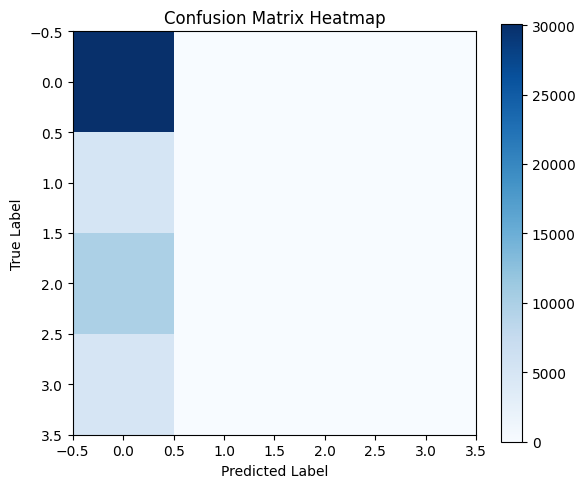

In [20]:
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Blues", interpolation="nearest")
plt.title("Confusion Matrix Heatmap")
plt.colorbar()
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

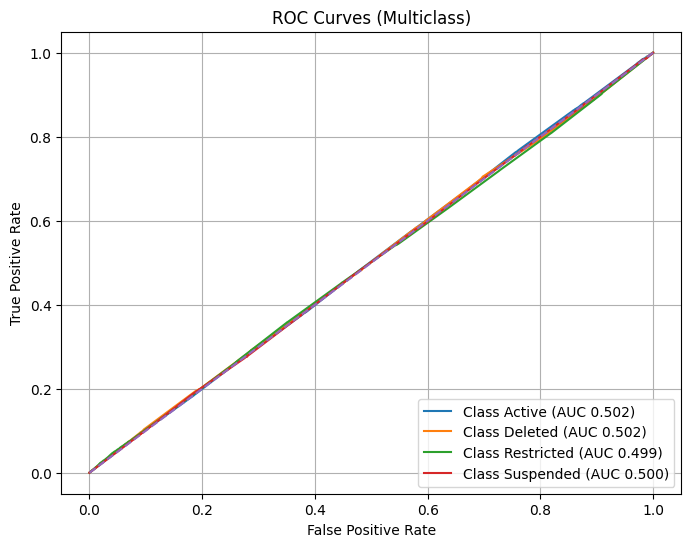

In [21]:
if n_classes == 2:
    fpr, tpr, _ = roc_curve(y_test, y_prob[:,1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0,1],[0,1],"--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
else:
    y_test_bin = label_binarize(y_test, classes=range(n_classes))
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:,i], y_prob[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    plt.figure(figsize=(8,6))
    for i in range(min(5, n_classes)):
        plt.plot(fpr[i], tpr[i], label=f"Class {classes[i]} (AUC {roc_auc[i]:.3f})")
    plt.plot([0,1],[0,1],"--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (Multiclass)")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()




